Duplicate key in file WindowsPath('C:/Users/tauyu/anaconda/lib/site-packages/matplotlib/mpl-data/matplotlibrc'), line 257 ('font.family:  IPAexGothic')


<IPython.core.display.Javascript object>


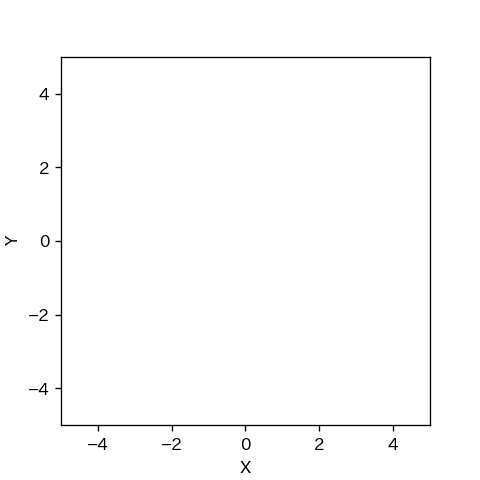

In [1]:
import sys
sys.path.append("../scripts/")
from mcl import *

In [2]:
class ResetMcl(Mcl):
    def __init__(self,envmap,init_pose,num,motion_noise_stds={"nn":0.19,"no":0.001,"on":0.13,"oo":0.2},
                distance_dev_rate=0.14,direction_dev=0.05,alpha_threshold=0.001,expansion_rate=0.2):
        super().__init__(envmap,init_pose,num,motion_noise_stds,distance_dev_rate,direction_dev)
        self.alpha_threshold=alpha_threshold
        self.expansion_rate=expansion_rate
        self.counter=0
        
    def random_reset(self):
         for p in self.particles:
                p.pose=np.array([np.random.uniform(-5.0,5,0),np.random.uniform(-5.0,5.0),np.random.uniform(-math.pi,math.pi)]).T
                p.weight=1/len(self.particles)
    
    def sensor_resetting_draw(self,particle,landmark_pos,ell_obs,phi_obs):
             ##パーティクルの位置を決める##
                psi=np.random.uniform(-np.pi,np.pi) #ランドマークからの方角を選ぶ
                ell=norm(loc=ell_obs,scale=(ell_obs*self.distance_dev_rate)**2).rvs() #ランドマークからの距離を選ぶ
                particle.pose[0]=landmark_pos[0]+ell*math.cos(psi)
                particle.pose[1]=landmark_pos[1]+ell*math.sin(psi)
                
            ##パーティクルの向きを決める##
                phi=norm(loc=phi_obs,scale=(self.direction_dev)**2).rvs() #ランドマークが見える向きを決める
                particle.pose[2]=math.atan2(landmark_pos[1]-particle.pose[1],landmark_pos[0]-particle.pose[0])-phi
            
                particle.weight=1.0/len(self.particles) #重みを1/Nに
            
    def sensor_resetting(self,observation):
        d=list([obs[0][0] for obs in observation])
        if len(d)==2:
            nearest_obs=np.argmin([obs[0][0] for obs in observation]) #最小値の位置=最小値の位置を求める関数(idを含むセンサ値のリスト)
            values1, landmark_id1=observation[nearest_obs]#単なるセンサ値のリスト
            b = sorted(d).index(sorted(d)[1]) #ただのセンサ値
            values2, landmark_id2 = observation[b]   #bの型がおかしい可能性がある b(センサ値)の場所をobservation[]のかっこに入れる
            for p in self.particles:
                self.sensor_resetting_draw(p, self.map.landmarks[landmark_id1].pos, *values1)
                self.sensor_resetting_draw(p, self.map.landmarks[landmark_id2].pos, *values2)
                
            print(d)
            
            
        elif len(d)==1:
            nearest_obs3=np.argmin([obs[0][0] for obs in observation])
            values3, landmark_id3=observation[nearest_obs3]
            
            for p in self.particles:
                self.sensor_resetting_draw(p, self.map.landmarks[landmark_id3].pos, *values3)
                
            print(d)
            
    def expansion_resetting(self):
        for p in self.particles:
            p.pose+=multivariate_normal(cov=np.eye(3)*(self.expansion_rate**2)).rvs()
            p.weight=1.0/len(self.particles)
            
    def observation_update(self,observation):
        for p in self.particles:
            p.observation_update(observation,self.map,self.distance_dev_rate,self.direction_dev)
     
        self.set_ml()
        
        if sum([p.weight for p in self.particles]) < self.alpha_threshold:
            self.counter += 1
            if self.counter < 5:
                self.expansion_resetting() #expansion_resettingに変更
            else:
                self.sensor_resetting(observation)
        else:
            self.counter=0
            self.resampling()

C:\Users\tauyu\anaconda\lib\site-packages\matplotlib\animation.py:889: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you have outputted the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


In [3]:
def trial_phantom_kidnap(animation): ###mclkidnap1test
    time_interval=0.1
    world=World(30,time_interval,debug=not animation)
    
    ##地図を生成して3つランドマークを追加##
    m=Map()
    m.append_landmark(Landmark(-4,2))
    m.append_landmark(Landmark(2,-3))
    m.append_landmark(Landmark(3,3))
    world.append(m)
    
    ##ロボットを作る##
    init_pose=np.array([np.random.uniform(-5.0,5.0),np.random.uniform(-5.0,5.0),np.random.uniform(-math.pi,math.pi)]).T
    robot_pose=np.array([np.random.uniform(-5.0,5.0),np.random.uniform(-5.0,5.0),np.random.uniform(-math.pi,math.pi)]).T
    pf=ResetMcl(m,init_pose,100)
    a=EstimationAgent(time_interval,0.2,10.0/180*math.pi,pf)
    r=Robot(robot_pose,sensor=Camera(m,phantom_prob=0.1),agent=a,color="red")
    world.append(r)
    
    world.draw()
    
    return(r.pose, pf.ml.pose)

<IPython.core.display.Javascript object>


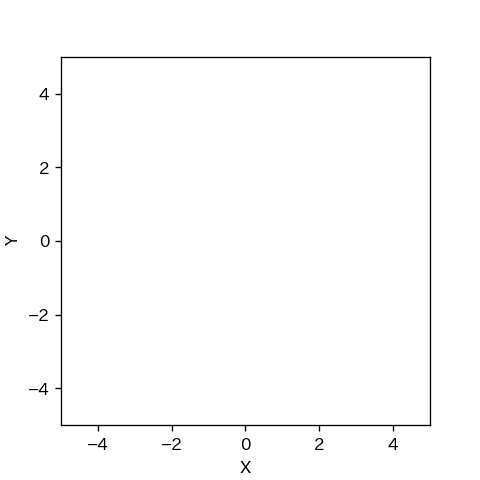

(array([ 4.84910064,  3.12281214, -0.88619832]),
 array([-1.42054747,  2.71010737, -2.7814992 ]))

In [4]:
trial_phantom_kidnap(True)

In [5]:
if __name__=='__main__': ###mclglobal1exec
    ok=0
    for i in range(1000):
        actual, estm=trial_phantom_kidnap(False)
        diff = math.sqrt((actual[0]-estm[0])**2 + (actual[1]-estm[1])**2)
        print(i, "真値:",actual, "推定値:", estm, "誤差:", diff)
        if diff<=1.0:
            ok += 1
            print(ok)

[4.792279012470423]
0 真値: [0.24365031 1.6402792  4.2834535 ] 推定値: [0.63073106 1.33403709 4.13250807] 誤差: 0.4935744497336487
1
[1.6122797457519211]
1 真値: [ 0.65417365 -0.9758213   5.1288909 ] 推定値: [ 0.99009578 -1.04027768  5.06349981] 誤差: 0.34205014629341474
2
[2.6143343678916215]
[2.0999011358670217]
[5.852192766035139]
[3.5286640153769984]
2 真値: [-2.77991788  4.74442877  3.58392533] 推定値: [-4.9173975  -0.95940532  0.52973472] 誤差: 6.091185638515392
[3.8898032952789894, 4.7415851141751855]
[5.1642567585822725]
3 真値: [-1.00139348 -3.77992505  5.05394602] 推定値: [-7.61782667  7.32352875  2.01053734] 誤差: 12.9253191211404
4 真値: [-4.58510437 -1.22090274  6.26821864] 推定値: [-0.82533547  1.93964938  8.85171147] 誤差: 4.911715782642013
[4.633798377899144]
[3.2332941794107817]
5 真値: [5.88521262 2.5428443  2.41798608] 推定値: [ 4.93341035  4.79562109 -3.01332748] 誤差: 2.4455941631557336
[2.529072887258733, 5.928410130255496]
[3.1525703772552585]
[2.5181734591407157, 5.654412818042976]
[2.7940194827697793, 

C:\Users\tauyu\section_advanced_localization\../scripts\ideal_robot.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(4,4))


[2.5196022742880113]
20 真値: [ 0.61419729 -3.63013759  3.60310369] 推定値: [ 1.31799857 -2.37309643  1.87347055] 誤差: 1.4406556567469537
[5.208839506603073]
21 真値: [ 2.67173193 -1.58305842  6.57701551] 推定値: [ 3.31527207 -2.00448355  5.6004109 ] 誤差: 0.7692483726539734
12
[6.564116984986262]
22 真値: [-1.62341438 -2.28535312  1.83804004] 推定値: [ 0.41375563 -0.40876219  2.35415179] 誤差: 2.7697752881086015
[2.383397861828334]
23 真値: [-0.39187056 -4.01185197  4.94217719] 推定値: [ 1.69105326 -2.73054271  3.12916842] 誤差: 2.4454703181197877
[2.745777967707911]
[5.900407124003958]
24 真値: [-2.21076487 -1.75819864  7.49943893] 推定値: [-1.83664827 -0.78701715  1.42116555] 誤差: 1.040748144322303
[5.346396682368397]
25 真値: [-3.73431609 -2.57889706  7.40680525] 推定値: [-3.96794643 -2.73355552  1.08667047] 誤差: 0.2801827499708245
13
[3.948018436918972]
26 真値: [ 3.71423064 -4.80278563  3.43289001] 推定値: [-0.51485391 -3.14499912  1.12607505] 誤差: 4.542401591326984
[5.073554232412495]
27 真値: [-2.19726163 -0.70806865  2.708